<a href="https://colab.research.google.com/github/ttogle918/NLU_3-/blob/main/practice/%EC%B5%9C%EC%A7%80%ED%98%84_sts_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLU - 문장 유사도 계산 (STS)**



- RoBERTa 적용
  - klue/roberta-base

참고 : 
- [code](https://www.datafied.world/detailed-notebook-to-fine-tune-roberta-for-beginners-222)
- [huggingface RobertaModel](https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel)
- [huggingface git](https://github.com/huggingface/transformers/blob/v4.19.2/src/transformers/models/roberta/modeling_roberta.py#L692)
- [huggingface models](https://huggingface.co/models)

In [ ]:
!pip install optuna
!pip install pytorch-transformers
!pip install transformers
!pip install datasets

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
from scipy import stats
import time
import matplotlib.pyplot as plt

In [3]:
# gpu 연산이 가능하면 'cuda:0', 아니면 'cpu' 출력
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.device_count()

(device(type='cuda', index=0), 1)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from transformers import AutoTokenizer, AutoModel, RobertaConfig
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

# Load dataset

### KLUE 데이터셋 및 전처리 과정 예시

[klue-sts-벤치마크-구조-보기](https://velog.io/@soyoun9798/KLUE-STS-%EB%B2%A4%EC%B9%98%EB%A7%88%ED%81%AC-%EA%B5%AC%EC%A1%B0-%EB%B3%B4%EA%B8%B0)


In [6]:
from datasets import load_dataset
dataset = load_dataset('klue', 'sts')

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
print(f"type(dataset) : {type(dataset)}")
print(f"key : {dataset.keys()}")
print(f"type dataset[train] : {type(dataset['train'])}")
print(f"dataset[train] : {dataset['train']} \n\n")
# labels : { 이진분류 : 1, 반올림 값 : 3.7, 실제 label 값 : 3.71422... }
dataset['train'][0]

type(dataset) : <class 'datasets.dataset_dict.DatasetDict'>
key : dict_keys(['train', 'validation'])
type dataset[train] : <class 'datasets.arrow_dataset.Dataset'>
dataset[train] : Dataset({
    features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
    num_rows: 11668
}) 




{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [7]:
# 데이터 4개만 확인
i = 0
for d in dataset['train'] :
  if i == 4 : break
  print(d['sentence1'],'/',  d['sentence2'])
  i += 1

숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다. / 숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.
위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다. / 시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.
회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘. / 사람들이 주로 네이버 메일을 쓰는 이유를 알려줘
긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업성공패키지, 청년구직활동지원금, 긴급복지지원제도 지원금과는 중복 수급이 불가능하다. / 고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.


In [9]:
import re
i = 0
for d in dataset['train'] :
  if i == 4 : break
  print(re.sub('[^가-힣A-Za-z0-9]','', d['sentence1']),'/',  re.sub('[^가-힣A-Za-z0-9]','', d['sentence2']))
  i += 1

숙소위치는찾기쉽고일반적인한국의반지하숙소입니다 / 숙박시설의위치는쉽게찾을수있고한국의대표적인반지하숙박시설입니다
위반행위조사등을거부방해기피한자는500만원이하과태료부과대상이다 / 시민들스스로자발적인예방노력을한것은아산뿐만이아니었다
회사가보낸메일은이지메일이아니라다른지메일계정으로전달해줘 / 사람들이주로네이버메일을쓰는이유를알려줘
긴급고용안정지원금은지역고용대응등특별지원금지자체별소상공인지원사업취업성공패키지청년구직활동지원금긴급복지지원제도지원금과는중복수급이불가능하다 / 고용보험이1차고용안전망이라면국민취업지원제도는2차고용안전망입니다


In [12]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

result = tokenizer(re.sub('[^가-힣]','', dataset['train']['sentence1'][0]), re.sub('[^가-힣]','', dataset['train']['sentence2'][0]))
print('input_ids', result.input_ids)
print('token_type_ids', result.token_type_ids)
print('attention_mask', result.attention_mask)
print(tokenizer.decode(result['input_ids']))

input_ids [0, 9206, 12765, 2259, 2688, 2015, 2961, 2088, 2210, 2536, 31221, 2470, 2226, 2079, 2536, 2118, 2205, 2300, 2024, 12190, 2, 8134, 10171, 2079, 12765, 2259, 2961, 2318, 2688, 2069, 2113, 2689, 2088, 2470, 2226, 2079, 5718, 31221, 2536, 2118, 2205, 2300, 2042, 10171, 12190, 2]
token_type_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[CLS] 숙소위치는찾기쉽고일반적인한국의반지하숙소입니다 [SEP] 숙박시설의위치는쉽게찾을수있고한국의대표적인반지하숙박시설입니다 [SEP]


In [20]:
model = AutoModel.from_pretrained('klue/roberta-base')#, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')
result = tokenizer(dataset['train']['sentence1'][0], dataset['train']['sentence2'][0], return_tensors='pt')
outputs = model(**result)
# 'textattack/roberta-base-STS-B'

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [16]:
outputs['pooler_output'].shape, outputs['last_hidden_state'].shape, 

(torch.Size([1, 768]), torch.Size([1, 41, 768]))

In [22]:
del outputs
del model
del tokenizer
del result

# Dataset Tokenizing -> dataLoader

In [7]:
import re
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataset, appended_data=None, appended_data2=None):
        self.sentence1, self.sentence2, self.labels = self.make_dataset(dataset, appended_data, appended_data2)

    def make_dataset(self, dataset, appended_data=None, appended_data2=None):
        """
        self.label : dataset의 label의 list
        self.input : sentence1, sentence2를 tokenizer한 값을 이어 붙임 
        rlabels : # real-label -> 0 ~ 5일 때, binary-label : 0 or 1
        """
        sentence1, sentence2, rlabels = [], [], []

        for data in dataset :
          # rlabels.append(data['labels']['real-label'])
          rlabels.append(data['labels']['binary-label'])
          sentence1.append(self.cleaning(data['sentence1']))
          sentence2.append(self.cleaning(data['sentence2']))

        if appended_data is not None :
          for data in appended_data :
            if data['score'] is None or data['sentence1'] is None or data['sentence2'] is None :
              continue 
            rlabels.append(data['score'])
            sentence1.append(self.cleaning(data['sentence1']))
            sentence2.append(self.cleaning(data['sentence2']))

        if appended_data2 is not None :
          for data in appended_data2 :
            if data['score'] is None or data['sentence1'] is None or data['sentence2'] is None :
              continue
            rlabels.append(data['score'])
            sentence1.append(self.cleaning(data['sentence1']))
            sentence2.append(self.cleaning(data['sentence2']))
        return sentence1, sentence2, rlabels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentence1[idx], self.sentence2[idx], self.labels[idx]

    def cleaning(self, sentence) :
        # return re.sub('[^가-힣A-Za-z0-9]','', sentence)
        return sentence

In [9]:
def custom_collate_fn(batch):
    input1_list, input2_list, target_list = [], [], []

    for _input1, _input2, _target in batch:
        input1_list.append(_input1)
        input2_list.append(_input2)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input1_list, input2_list,
        add_special_tokens=True,
        padding="longest",  # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    tensorized_label = torch.tensor(target_list)

    return tensorized_input, tensorized_label

In [10]:
def make_dataloader(dataset, tok_model, batch_size, s='train') :
  global tokenizer
  tokenizer = AutoTokenizer.from_pretrained(tok_model)
  if s == 'train' :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = RandomSampler(dataset),
        collate_fn = custom_collate_fn
    )
  else :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = SequentialSampler(dataset),
        collate_fn = custom_collate_fn
    )
  print(f'batch_size : {batch_size}')
  return dataloader

# model class

In [23]:
class CustomBertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score
# 모델 클래스
class CustomSTS(nn.Module):
    def __init__(self, model_name):
        super(CustomSTS, self).__init__()
        self.config = RobertaConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.cls = CustomBertOnlyNSPHead(self.config)
        self.softmax = nn.Softmax(dim=1)
        self.classifier = nn.Sequential(
          nn.Linear(768, 32),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(32, 2)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        """
        outputs(NextSentencePredictorOutput) : logtis, loss(next_sentence_label이 주어질 때 return)
                                              hidden_states(optional), attentions(optional) 을 가지고 있다.
        loss는 주어진 label이 0~5 사이의 값으로 scale 되어있기 때문에 직접 구해야한다!

        """
        # logits's shape : (batch_size, seq_len, 2)
        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )['last_hidden_state']
        logits = self.classifier(outputs)[:, 0, :]
        probs = self.softmax(logits)
        # probs = probs[:, 0] * 5    # 0~5 사이의 값으로 정답(T)일 확률 뽑아내기
        return probs    # 정답(T)일 확률, 정답일때 1 

# train

### model, optimizer, scheduler 초기화

In [12]:
def initializer(train_dataloader, epochs=2, model_name='snunlp/KR-Medium', lr=4e-5, wd=4e-5):
    """
    모델, 옵티마이저, 스케쥴러 초기화
    """
    model = CustomSTS(model_name=model_name)   # hidden size?

    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=lr,    # 2e-5
        eps=1e-8,
        weight_decay=wd
    )
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, # 여기서는 warmup을 사용하지 않는다.
        num_training_steps = total_steps
    )
    print(f'model_name : {model_name}, lr : {lr}, weight_decay : {wd}, epochs : {epochs}')
    return model, optimizer, scheduler

### checkpoint

In [13]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss, f1, model_name=''):
    file_name = f'{path}/epoch:{epoch}_loss:{loss:.4f}_f1:{f1:.4f}.ckpt'
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss,
            'f1' : f1
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

### train code

In [14]:
before_loss, before_f1 = 0.4, 0.7

In [15]:
def train(model, optimizer, scheduler, train_dataloader, valid_dataloader=None, epochs=1, model_name=''):
  loss_fct = nn.MSELoss()
  train_dict = {'loss' : [], 'f1' : []}
  valid_dict = {'loss' : [], 'f1' : []}
  global before_loss, before_f1
  for epoch in range(epochs) :

    print(f"*****Epoch {epoch} Train Start*****")
    # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
    total_loss, total_f1, batch_f1, batch_loss, batch_count = 0,0,0,0,0
    
    # model을 train 모드로 설정 & device 할당
    model.train()
    model.to(device)
    
    # data iterator를 돌면서 하나씩 학습
    for step, batch in enumerate(train_dataloader):
      batch_count+=1
      
      # tensor 연산 전, 각 tensor에 device 할당
      batch = tuple(item.to(device) for item in batch)
      
      batch_input, batch_label = batch
      labels = torch.tensor([[1, 0] if label == 1 else [0, 1] for label in batch_label]).to(device)

      # batch마다 모델이 갖고 있는 기존 gradient를 초기화
      model.zero_grad()
      
      # forward
      probs = model(**batch_input)
      pred = torch.argmin(probs, dim=1).cpu()   # [0, 1]이면 Fasle, Batch_label은 0, [1,0]이면 True, Batch_label은 1

      # loss
      loss = loss_fct(labels.to(torch.float32), probs.to(torch.float32))
      batch_loss += loss.item()
      total_loss += loss.item()

      # f1-score
      f1 = f1_score(pred, [b.cpu() for b in batch_label])
      batch_f1 += f1
      total_f1 += f1

      # backward -> 파라미터의 미분(gradient)를 자동으로 계산
      loss.backward()

      # gradient clipping 적용 
      clip_grad_norm_(model.parameters(), 1.0)
      
      # optimizer & scheduler 업데이트
      optimizer.step()
      scheduler.step()

      # 그래디언트 초기화
      model.zero_grad()

      # 배치 128개씩 처리할 때마다 평균 loss와 lr를 출력
      if (step % 128 == 0 and step != 0):
          learning_rate = optimizer.param_groups[0]['lr']
          print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate:.10f}, Avg Loss : {batch_loss / batch_count:.4f}, f1 score : {batch_f1 / batch_count:.4f}")
          
          if (round(batch_f1 / batch_count, 5) == 0) and (round(learning_rate, 10) == 0) :
              print("Train Finished, learning_rate is 0 and train_f1 is 0")
              return train_dict, valid_dict

          # 변수 초기화
          batch_loss, batch_f1, batch_count = 0,0,0


    print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
    print(f"Epoch {epoch} Total Mean f1 : {total_f1/(step+1):.4f}")
    print(f"*****Epoch {epoch} Train Finish*****\n")

    train_dict['f1'].append(total_f1/(step+1))
    train_dict['loss'].append(total_loss/(step+1))
    
    if valid_dataloader is not None:
        print(f"*****Epoch {epoch} Valid Start*****")
        valid_loss, valid_acc, valid_f1 = validate(model, valid_dataloader)
        print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.4f} Valid f1 : {valid_f1:.4f}")
        print(f"*****Epoch {epoch} Valid Finish*****\n")

    valid_dict['f1'].append(valid_f1)
    valid_dict['loss'].append(valid_loss)
    if round(valid_f1, 4) == 0 :
        break
    if before_loss > valid_loss :
        before_loss = valid_loss
        save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_f1, model_name)

    elif before_f1 < valid_f1  :
        before_f1 = valid_f1
        save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_f1, model_name)

  print("Train Finished")
  return train_dict, valid_dict

### validation code

In [16]:
def validate(model, valid_dataloader):
    loss_fct = nn.MSELoss()
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc, total_f1, = 0,0, 0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
        labels = torch.tensor([[1, 0] if label == 1 else [0, 1] for label in batch_label]).to(device)
            
        # gradient 계산하지 않음
        with torch.no_grad():
            probs = model(**batch_input)
        pred = torch.argmin(probs, dim=1).cpu()
            
        # loss
        loss = loss_fct(probs.to(torch.float32), labels.to(torch.float32))
        total_loss += loss.item()
        
        # accuracy
        acc = 0
        for p, b in zip(pred, batch_label) :
          if p == b :
            acc += 1
        
        acc = acc / len(pred)
        total_acc+=acc
        
        # f1-score
        f1 = f1_score(pred, [b.cpu() for b in batch_label])
        total_f1 += f1

    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)
    total_f1 = total_f1/(step+1)
    return total_loss, total_acc, total_f1

### draw_plot

In [17]:
# loss와 f1-score의 변화를 epoch마다 보기 위한 plot
def draw_plot(train_dict, valid_dict, i) :
  print('green is loss, gray is f1')
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.title('Loss and F1 of Train data')
  x_values= [n for n in range(len(train_dict['loss']))]
  plt.plot(x_values, train_dict['loss'], color='green', marker='o')  # loss
  plt.plot(x_values, train_dict['f1'], color='#AAAAAA', marker='*')  # f1

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.title('Loss and F1 of Validation data')
  x_values= [n for n in range(len(valid_dict['loss']))]
  plt.plot(x_values, valid_dict['loss'], color='green', marker='o')  # loss
  plt.plot(x_values, valid_dict['f1'], color='#AAAAAA', marker='*')  # f1

  plt.show()
  plt.savefig(f'figure_{i}.png')

# train

batch_size : 87
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 540
model_name : klue/roberta-base, lr : 5e-05, weight_decay : 0.01, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000380556, Avg Loss : 0.0662, f1 score : 0.8991
Epoch 0 Total Mean Loss : 0.0663
Epoch 0 Total Mean f1 : 0.8988
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1304 Valid Acc : 0.8196 Valid f1 : 0.8125
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.1304_f1:0.8125.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000255556, Avg Loss : 0.0309, f1 score : 0.9627
Epoch 1 Total Mean Loss : 0.0308
Epoch 1 Total Mean f1 : 0.9627
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1763 Valid Acc : 0.7910 Valid f1 : 0.7937
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000130556, Avg Loss : 0.0195, f1 score : 0.9764
Epoch 2 To

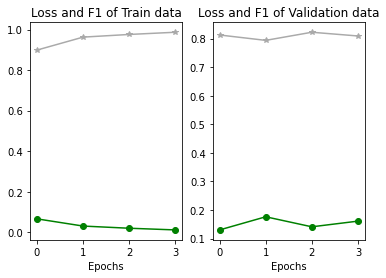

<Figure size 432x288 with 0 Axes>

In [21]:
# 'klue/roberta-base', 64, 32, lr : 5e-05, weight_decay : 0.01 -> 0.8381
# 'klue/roberta-base', 87, 32, lr : 5e-05, weight_decay : 0.01, layer : 32 -> 0.8392
# layer : 64 -> 0.8348
# 'klue/roberta-base', 80, 32, lr : 5e-05, 0.01 , layer -> 64->32 -> 0.8222
# 'klue/roberta-base', 87, 32, lr : 5e-05, 0.01 , layer -> 32->16 -> 0.8044
# 'klue/roberta-base', 87, 32, lr : 5e-05, 0.01 , layer -> 16 -> 0.8044
train_batch_size = 87
model_name = 'klue/roberta-base'

train_dataset = CustomDataset(dataset['train'])
valid_dataset = CustomDataset(dataset['validation'])

train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')
learning_rate = 5e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 4, model_name, learning_rate, weight_decay)

start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 4, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

draw_plot(train_dict, valid_dict, 0)

# hyperparameter 조정

[optuna 사용법](https://dacon.io/codeshare/2704)

- transformer의 trainer 사용
  - [trainer huggingface](https://huggingface.co/docs/transformers/main_classes/trainer)
  - [bert에 optuna 사용법-medium](https://medium.com/carbon-consulting/transformer-models-hyperparameter-optimization-with-the-optuna-299e185044a8)
  - [bert에 optuna 사용법-git블로그](https://thigm85.github.io/blog/search/cord19/bert/transformers/optuna/2020/11/07/bert-training-optuna-tuning.html)


In [17]:
import optuna

In [23]:
i = 0
def objective(trial: optuna.Trial):
    model_name = 'klue/roberta-base'
    learning_rate = trial.suggest_loguniform('learning_rate', low=5e-5, high=0.01)
    weight_decay = trial.suggest_loguniform('weight_decay', low=4e-5, high=0.01)

    train_batch_size = trial.suggest_int("per_device_train_batch_size", 16, 88)
    train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
    valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')
    
    model, optimizer, scheduler = initializer(train_dataloader, 4, model_name, learning_rate, weight_decay)
    start = time.time()
    train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 4, model_name)
    end = time.time()
    print(f"time : {(end - start)//60}분 {(end - start)%60}초")

    global i

    draw_plot(train_dict, valid_dict, i)
    i += 1

    gc.collect()
    print('\n------------------------------------------\n\n')
    return max(valid_dict['f1'])

In [24]:
train_dataset = CustomDataset(dataset['train'])
valid_dataset = CustomDataset(dataset['validation'])

In [26]:
import gc
gc.collect()

88

### klue/roberta-base

**train_batch_size, lr, weight_decay, epoch -> f1**


|step|||||f1||step|||||f1|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|- |64|5e-05|0.01||**0.8381**||layer(32)|87|5e-05|0.01||**0.8392**|
|layer(64, 32) |80|5e-05|0.01||0.8222||layer(64)|87|5e-05|0.01||**0.8348**|
|1. |81|0.0001|4.33e-05|4|0.8100||24.|45|0.0001|0.001|3|0.7674|
|9.|40|0.0001|0.0059|4|0.7986||25.|37|8e-05|0.005|4|0.8117|
|10.|19|0.0001|0.0001|1|0.5828||27.|25|8e-05|0.009|4|0.8159|
|11.|38|9e-05|0.0098|3|0.8258||29.|51|0.0001|0.0006|3|0.8201|
|13.|70|5e-05|5e-05|4|**0.8345**||31.|82|7e-05|0.0003|4|0.8275|
|14.|71|5e-05|0.0001|3|0.8181||32.|82|7e-05|0.0004|4|0.8287|
|16.|35|6e-05|0.0002|3|0.8113||34.|79|6e-05|0.0001|3|0.8145|
|21.|73|5e-05|9e-05|4|0.8074||35.|87|0.0001|6e-05|4|0.8096|
|22.|73|6e-05|0.00029|2|0.8251||36.|82|0.0001|0.0009|4|0.7898|
|23.|45|7e-05|0.0003|3|**0.8373**||38.|84|7e-05|0.0001|3|0.8185|
|||||||  |39.|69|5e-05|0.0003|4|0.8266|











[I 2022-06-08 17:13:45,147] A new study created in memory with name: hyper-parameter-search


klue/roberta-base


batch_size : 88
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 532
model_name : klue/roberta-base, lr : 0.009869577882559828, weight_decay : 0.0077246634149112925, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0074763908, Avg Loss : 0.2552, f1 score : 0.0953
Epoch 0 Total Mean Loss : 0.2550
Epoch 0 Total Mean f1 : 0.0925
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2481 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 40.35153889656067초
green is loss, gray is f1


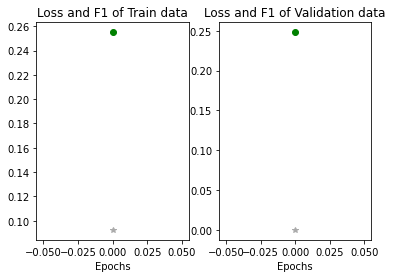

[I 2022-06-08 17:15:39,997] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.009869577882559828, 'weight_decay': 0.0077246634149112925, 'per_device_train_batch_size': 88}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 81
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 580
model_name : klue/roberta-base, lr : 0.00013826926088511616, weight_decay : 4.331965360396003e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001075163, Avg Loss : 0.0893, f1 score : 0.8472
Epoch 0 Total Mean Loss : 0.0871
Epoch 0 Total Mean f1 : 0.8547
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1372 Valid Acc : 0.8380 Valid f1 : 0.8097
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.1372_f1:0.8097.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000729490, Avg Loss : 0.0458, f1 score : 0.9424
Epoch 1 Total Mean Loss : 0.0452
Epoch 1 Total Mean f1 : 0.9429
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1313 Valid Acc : 0.8138 Valid f1 : 0.7960
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:1_loss

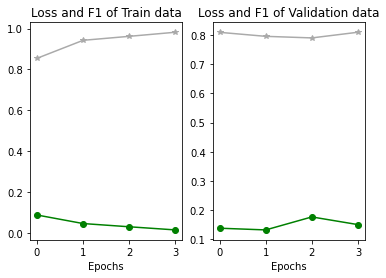

[I 2022-06-08 17:22:57,552] Trial 1 finished with value: 0.8100237504389753 and parameters: {'learning_rate': 0.00013826926088511616, 'weight_decay': 4.331965360396003e-05, 'per_device_train_batch_size': 81}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 45
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1040
model_name : klue/roberta-base, lr : 0.009869457358232596, weight_decay : 0.0023692942804177655, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0086452651, Avg Loss : 0.2653, f1 score : 0.1566
Epoch: 0, Step : 256, LR : 0.0074305626, Avg Loss : 0.2497, f1 score : 0.0000
Epoch 0 Total Mean Loss : 0.2574
Epoch 0 Total Mean f1 : 0.0777
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2456 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 44.517805099487305초
green is loss, gray is f1


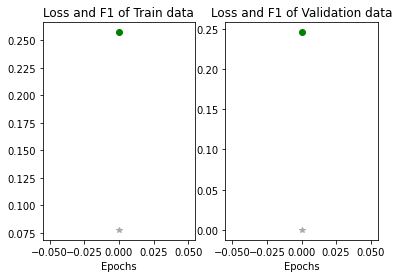

[I 2022-06-08 17:24:56,772] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.009869457358232596, 'weight_decay': 0.0023692942804177655, 'per_device_train_batch_size': 45}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 76
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 616
model_name : klue/roberta-base, lr : 0.009269070920589378, weight_decay : 0.0030174596368868893, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0073279830, Avg Loss : 0.4716, f1 score : 0.0147
Epoch 0 Total Mean Loss : 0.4755
Epoch 0 Total Mean f1 : 0.0123
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.4175 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 41.309600830078125초
green is loss, gray is f1


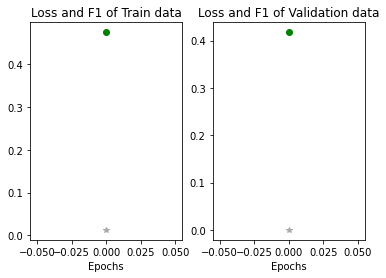

[I 2022-06-08 17:26:52,515] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.009269070920589378, 'weight_decay': 0.0030174596368868893, 'per_device_train_batch_size': 76}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 57
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 820
model_name : klue/roberta-base, lr : 0.004399744748013493, weight_decay : 0.0010040681421018718, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0037075898, Avg Loss : 0.2575, f1 score : 0.2300
Epoch 0 Total Mean Loss : 0.2547
Epoch 0 Total Mean f1 : 0.1447
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2481 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 43.28410315513611초
green is loss, gray is f1


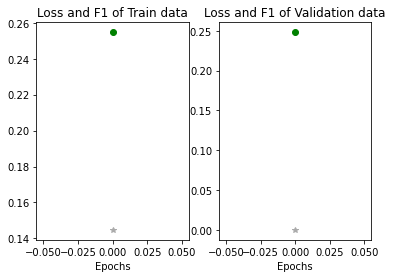

[I 2022-06-08 17:28:50,289] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 0.004399744748013493, 'weight_decay': 0.0010040681421018718, 'per_device_train_batch_size': 57}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 56
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 836
model_name : klue/roberta-base, lr : 0.006080310444261164, weight_decay : 4.283008022837476e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0051420807, Avg Loss : 0.2544, f1 score : 0.1862
Epoch 0 Total Mean Loss : 0.2527
Epoch 0 Total Mean f1 : 0.1150
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2478 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 43.005677938461304초
green is loss, gray is f1


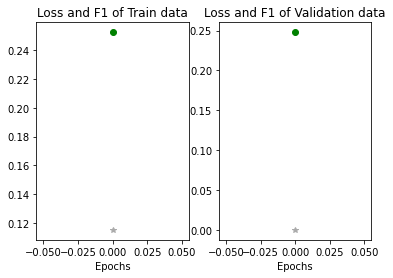

[I 2022-06-08 17:30:47,767] Trial 5 finished with value: 0.0 and parameters: {'learning_rate': 0.006080310444261164, 'weight_decay': 4.283008022837476e-05, 'per_device_train_batch_size': 56}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 54
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 868
model_name : klue/roberta-base, lr : 0.001083502229642499, weight_decay : 0.0001224521528346411, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0009224748, Avg Loss : 0.2516, f1 score : 0.1932
Epoch 0 Total Mean Loss : 0.2510
Epoch 0 Total Mean f1 : 0.3399
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2505 Valid Acc : 0.4175 Valid f1 : 0.5857
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0006515993, Avg Loss : 0.2499, f1 score : 0.1379
Epoch 1 Total Mean Loss : 0.2499
Epoch 1 Total Mean f1 : 0.0820
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.2482 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 1 Valid Finish*****

Train Finished
time : 3.0분 26.20087504386902초
green is loss, gray is f1


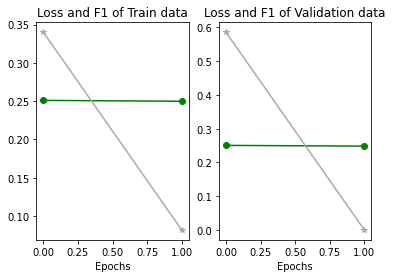

[I 2022-06-08 17:34:28,740] Trial 6 finished with value: 0.585747622409982 and parameters: {'learning_rate': 0.001083502229642499, 'weight_decay': 0.0001224521528346411, 'per_device_train_batch_size': 54}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 87
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 540
model_name : klue/roberta-base, lr : 0.0009600888253898992, weight_decay : 0.003091274454576633, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0007307343, Avg Loss : 0.2542, f1 score : 0.3295
Epoch 0 Total Mean Loss : 0.2540
Epoch 0 Total Mean f1 : 0.3163
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2434 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 39.93442416191101초
green is loss, gray is f1


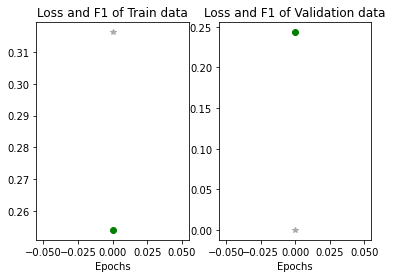

[I 2022-06-08 17:36:23,127] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.0009600888253898992, 'weight_decay': 0.003091274454576633, 'per_device_train_batch_size': 87}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 50
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 936
model_name : klue/roberta-base, lr : 0.0017844658457451914, weight_decay : 0.0004880445351291956, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0015385298, Avg Loss : 0.2530, f1 score : 0.3232
Epoch 0 Total Mean Loss : 0.2520
Epoch 0 Total Mean f1 : 0.3074
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2550 Valid Acc : 0.4175 Valid f1 : 0.5857
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0010924134, Avg Loss : 0.2501, f1 score : 0.3243
Epoch 1 Total Mean Loss : 0.2502
Epoch 1 Total Mean f1 : 0.3023
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.2477 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 1 Valid Finish*****

Train Finished
time : 3.0분 27.029114246368408초
green is loss, gray is f1


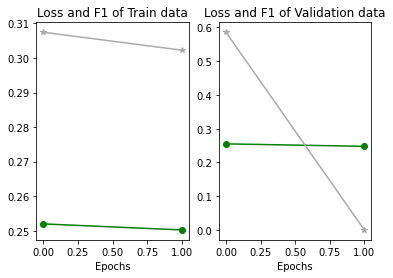

[I 2022-06-08 17:40:05,016] Trial 8 finished with value: 0.585747622409982 and parameters: {'learning_rate': 0.0017844658457451914, 'weight_decay': 0.0004880445351291956, 'per_device_train_batch_size': 50}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 40
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1168
model_name : klue/roberta-base, lr : 0.00010168117111744502, weight_decay : 0.00597341717031394, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000904510, Avg Loss : 0.1207, f1 score : 0.8185
Epoch: 0, Step : 256, LR : 0.0000793078, Avg Loss : 0.0624, f1 score : 0.9193
Epoch 0 Total Mean Loss : 0.0874
Epoch 0 Total Mean f1 : 0.8763
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1812 Valid Acc : 0.7918 Valid f1 : 0.7842
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000650307, Avg Loss : 0.0441, f1 score : 0.9456
Epoch: 1, Step : 256, LR : 0.0000538875, Avg Loss : 0.0395, f1 score : 0.9469
Epoch 1 Total Mean Loss : 0.0421
Epoch 1 Total Mean f1 : 0.9464
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.2244 Valid Acc : 0.7237 Valid f1 : 0.7323
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch:

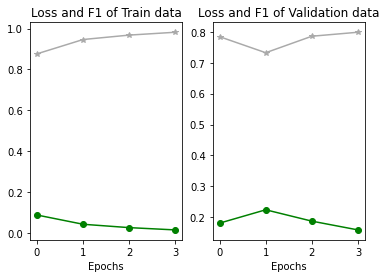

[I 2022-06-08 17:47:23,020] Trial 9 finished with value: 0.7985697170664136 and parameters: {'learning_rate': 0.00010168117111744502, 'weight_decay': 0.00597341717031394, 'per_device_train_batch_size': 40}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 19
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 2460
model_name : klue/roberta-base, lr : 0.00012477943546822094, weight_decay : 0.0001676411443427781, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001182361, Avg Loss : 0.1430, f1 score : 0.7464
Epoch: 0, Step : 256, LR : 0.0001117435, Avg Loss : 0.1361, f1 score : 0.8290
Epoch: 0, Step : 384, LR : 0.0001052509, Avg Loss : 0.1250, f1 score : 0.8299
Epoch: 0, Step : 512, LR : 0.0000987584, Avg Loss : 0.1273, f1 score : 0.8389
Epoch 0 Total Mean Loss : 0.1335
Epoch 0 Total Mean f1 : 0.8107
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2137 Valid Acc : 0.7130 Valid f1 : 0.5828
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000870413, Avg Loss : 0.1413, f1 score : 0.7785
Epoch: 1, Step : 256, LR : 0.0000805487, Avg Loss : 0.2295, f1 score : 0.2754
Epoch: 1, Step : 384, LR : 0.0000740561, Avg Loss : 0.2485, f1 score : 0.2440
Epoch: 1, Step : 512, L

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Total Mean Loss : 0.2185
Epoch 1 Total Mean f1 : 0.3556
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.2350 Valid Acc : 0.6284 Valid f1 : 0.2065
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000558464, Avg Loss : 0.2440, f1 score : 0.1081
Epoch: 2, Step : 256, LR : 0.0000493538, Avg Loss : 0.2441, f1 score : 0.0891
Epoch: 2, Step : 384, LR : 0.0000428612, Avg Loss : 0.2352, f1 score : 0.2255
Epoch: 2, Step : 512, LR : 0.0000363686, Avg Loss : 0.1697, f1 score : 0.6975
Epoch 2 Total Mean Loss : 0.2104
Epoch 2 Total Mean f1 : 0.3638
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****
Epoch 2 Valid Loss : 0.2210 Valid Acc : 0.6891 Valid f1 : 0.5033
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 128, LR : 0.0000246515, Avg Loss : 0.1617, f1 score : 0.7059
Epoch: 3, Step : 256, LR : 0.0000181590, Avg Loss : 0.2155, f1 score : 0.4318
Epoch: 3, Step : 384, LR :

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Total Mean Loss : 0.2148
Epoch 3 Total Mean f1 : 0.4275
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****
Epoch 3 Valid Loss : 0.2435 Valid Acc : 0.6027 Valid f1 : 0.1210
*****Epoch 3 Valid Finish*****

Train Finished
time : 7.0분 10.065274477005005초
green is loss, gray is f1


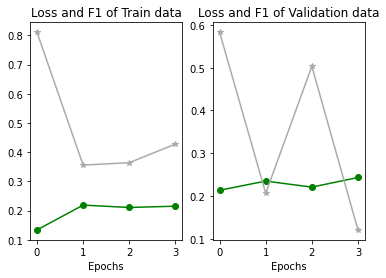

[I 2022-06-08 17:54:47,542] Trial 10 finished with value: 0.5827732508324738 and parameters: {'learning_rate': 0.00012477943546822094, 'weight_decay': 0.0001676411443427781, 'per_device_train_batch_size': 19}. Best is trial 1 with value: 0.8100237504389753.



------------------------------------------


batch_size : 38
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1232
model_name : klue/roberta-base, lr : 9.122297649951162e-05, weight_decay : 0.009871164157374166, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000816712, Avg Loss : 0.0872, f1 score : 0.8603
Epoch: 0, Step : 256, LR : 0.0000721935, Avg Loss : 0.0687, f1 score : 0.9180


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Total Mean Loss : 0.0760
Epoch 0 Total Mean f1 : 0.8907
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1841 Valid Acc : 0.7873 Valid f1 : 0.7488
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000588655, Avg Loss : 0.0532, f1 score : 0.9310
Epoch: 1, Step : 256, LR : 0.0000493878, Avg Loss : 0.0465, f1 score : 0.9442


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Total Mean Loss : 0.0477
Epoch 1 Total Mean f1 : 0.9365
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1521 Valid Acc : 0.8075 Valid f1 : 0.7897
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000360597, Avg Loss : 0.0323, f1 score : 0.9612
Epoch: 2, Step : 256, LR : 0.0000265820, Avg Loss : 0.0293, f1 score : 0.9606
Epoch 2 Total Mean Loss : 0.0297
Epoch 2 Total Mean f1 : 0.9624
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****
Epoch 2 Valid Loss : 0.1311 Valid Acc : 0.8380 Valid f1 : 0.8258
*****Epoch 2 Valid Finish*****

Saving epoch 2 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:2_loss:0.1311_f1:0.8258.ckpt
*****Epoch 3 Train Start*****
Epoch: 3, Step : 128, LR : 0.0000132540, Avg Loss : 0.0202, f1 score : 0.9764
Epoch: 3, Step : 256, LR : 0.0000037763, Avg Loss : 0.0166, f1 score : 0.9800
Epoch 3 Total Mean Loss : 0.0183
Epoch 3 Total Mean f1 : 0.9782
*****Epoch 

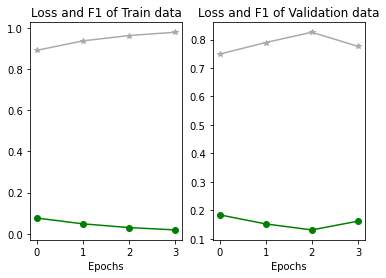

[I 2022-06-08 18:02:11,847] Trial 11 finished with value: 0.825769567541471 and parameters: {'learning_rate': 9.122297649951162e-05, 'weight_decay': 0.009871164157374166, 'per_device_train_batch_size': 38}. Best is trial 11 with value: 0.825769567541471.



------------------------------------------


batch_size : 28
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1668
model_name : klue/roberta-base, lr : 0.00024288736617466766, weight_decay : 0.00045861292246667553, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002241029, Avg Loss : 0.2521, f1 score : 0.2801
Epoch: 0, Step : 256, LR : 0.0002054641, Avg Loss : 0.2494, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0001868252, Avg Loss : 0.2502, f1 score : 0.0000
Epoch 0 Total Mean Loss : 0.2505
Epoch 0 Total Mean f1 : 0.0866
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2487 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 47.47777557373047초
green is loss, gray is f1


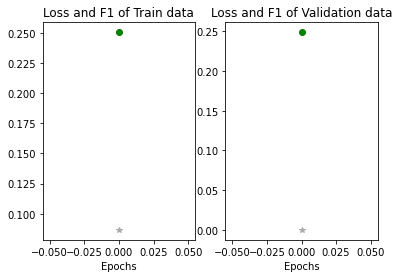

[I 2022-06-08 18:04:13,898] Trial 12 finished with value: 0.0 and parameters: {'learning_rate': 0.00024288736617466766, 'weight_decay': 0.00045861292246667553, 'per_device_train_batch_size': 28}. Best is trial 11 with value: 0.825769567541471.



------------------------------------------


batch_size : 70
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 668
model_name : klue/roberta-base, lr : 5.556702312758466e-05, weight_decay : 5.1179364509363895e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000448363, Avg Loss : 0.0783, f1 score : 0.8672
Epoch 0 Total Mean Loss : 0.0693
Epoch 0 Total Mean f1 : 0.8859
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2413 Valid Acc : 0.7329 Valid f1 : 0.7570
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000309445, Avg Loss : 0.0274, f1 score : 0.9635
Epoch 1 Total Mean Loss : 0.0270
Epoch 1 Total Mean f1 : 0.9641
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1465 Valid Acc : 0.8377 Valid f1 : 0.8278
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:1_loss:0.1465_f1:0.8278.ckpt
*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000170528, Avg Loss : 0.

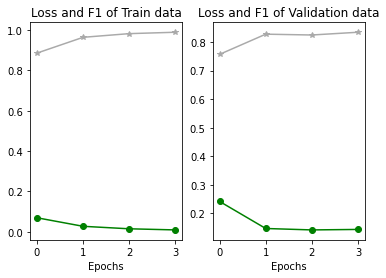

[I 2022-06-08 18:11:23,458] Trial 13 finished with value: 0.8345308559036908 and parameters: {'learning_rate': 5.556702312758466e-05, 'weight_decay': 5.1179364509363895e-05, 'per_device_train_batch_size': 70}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 71
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 660
model_name : klue/roberta-base, lr : 5.210319121127111e-05, weight_decay : 0.00013149381123269137, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000419194, Avg Loss : 0.0966, f1 score : 0.8388
Epoch 0 Total Mean Loss : 0.0858
Epoch 0 Total Mean f1 : 0.8617
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1766 Valid Acc : 0.7844 Valid f1 : 0.7939
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000288936, Avg Loss : 0.0372, f1 score : 0.9538
Epoch 1 Total Mean Loss : 0.0353
Epoch 1 Total Mean f1 : 0.9564
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1397 Valid Acc : 0.8277 Valid f1 : 0.8061
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000158678, Avg Loss : 0.0219, f1 score : 0.9731
Epoch 2 Total Mean Loss : 0.0219
Epoch 2 Total Mean f1 : 0.9726
*****Epoch 2 Train 

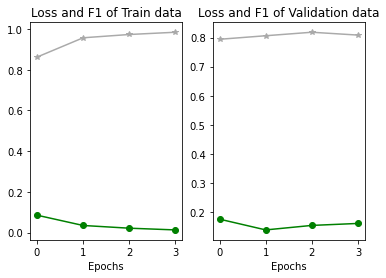

[I 2022-06-08 18:18:23,055] Trial 14 finished with value: 0.8180681320799517 and parameters: {'learning_rate': 5.210319121127111e-05, 'weight_decay': 0.00013149381123269137, 'per_device_train_batch_size': 71}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 67
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 700
model_name : klue/roberta-base, lr : 0.0003523890404889373, weight_decay : 0.0012775383961204508, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002874488, Avg Loss : 0.2511, f1 score : 0.3714
Epoch 0 Total Mean Loss : 0.2507
Epoch 0 Total Mean f1 : 0.3390
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2458 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 41.390246629714966초
green is loss, gray is f1


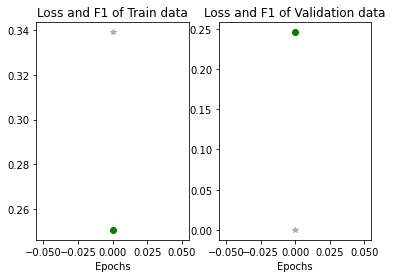

[I 2022-06-08 18:20:19,243] Trial 15 finished with value: 0.0 and parameters: {'learning_rate': 0.0003523890404889373, 'weight_decay': 0.0012775383961204508, 'per_device_train_batch_size': 67}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 35
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1336
model_name : klue/roberta-base, lr : 6.001121293727358e-05, weight_decay : 0.00021687813626212552, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000542167, Avg Loss : 0.0860, f1 score : 0.8550
Epoch: 0, Step : 256, LR : 0.0000484671, Avg Loss : 0.0489, f1 score : 0.9365
Epoch 0 Total Mean Loss : 0.0633
Epoch 0 Total Mean f1 : 0.9047
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1404 Valid Acc : 0.8057 Valid f1 : 0.8085
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000392139, Avg Loss : 0.0343, f1 score : 0.9544
Epoch: 1, Step : 256, LR : 0.0000334643, Avg Loss : 0.0311, f1 score : 0.9603
Epoch 1 Total Mean Loss : 0.0322
Epoch 1 Total Mean f1 : 0.9576
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1450 Valid Acc : 0.8251 Valid f1 : 0.8095
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoc

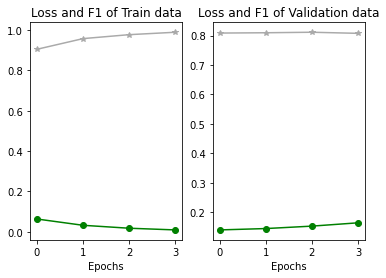

[I 2022-06-08 18:27:39,681] Trial 16 finished with value: 0.8112697071073064 and parameters: {'learning_rate': 6.001121293727358e-05, 'weight_decay': 0.00021687813626212552, 'per_device_train_batch_size': 35}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 65
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 720
model_name : klue/roberta-base, lr : 0.00032453262736768145, weight_decay : 0.0003063104186232896, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002663872, Avg Loss : 0.2515, f1 score : 0.2477
Epoch 0 Total Mean Loss : 0.2511
Epoch 0 Total Mean f1 : 0.2240
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2491 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 41.77054405212402초
green is loss, gray is f1


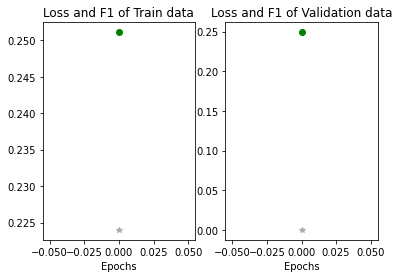

[I 2022-06-08 18:29:35,952] Trial 17 finished with value: 0.0 and parameters: {'learning_rate': 0.00032453262736768145, 'weight_decay': 0.0003063104186232896, 'per_device_train_batch_size': 65}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 30
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1556
model_name : klue/roberta-base, lr : 8.410382222381985e-05, weight_decay : 6.703157637651055e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000771312, Avg Loss : 0.2509, f1 score : 0.2666
Epoch: 0, Step : 256, LR : 0.0000702126, Avg Loss : 0.2518, f1 score : 0.0803
Epoch: 0, Step : 384, LR : 0.0000632941, Avg Loss : 0.2493, f1 score : 0.0000
Epoch 0 Total Mean Loss : 0.2506
Epoch 0 Total Mean f1 : 0.1148
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2466 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 47.89273953437805초
green is loss, gray is f1


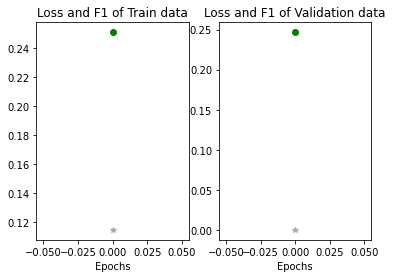

[I 2022-06-08 18:31:38,343] Trial 18 finished with value: 0.0 and parameters: {'learning_rate': 8.410382222381985e-05, 'weight_decay': 6.703157637651055e-05, 'per_device_train_batch_size': 30}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 20
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 2336
model_name : klue/roberta-base, lr : 0.00019659999697797003, weight_decay : 0.0009564958488846833, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001857432, Avg Loss : 0.2507, f1 score : 0.0832
Epoch: 0, Step : 256, LR : 0.0001749706, Avg Loss : 0.2507, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0001641980, Avg Loss : 0.2500, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0001534254, Avg Loss : 0.2497, f1 score : 0.0000
Epoch 0 Total Mean Loss : 0.2502
Epoch 0 Total Mean f1 : 0.0184
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2453 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 46.084516286849976초
green is loss, gray is f1


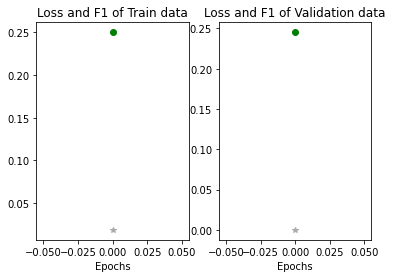

[I 2022-06-08 18:33:38,846] Trial 19 finished with value: 0.0 and parameters: {'learning_rate': 0.00019659999697797003, 'weight_decay': 0.0009564958488846833, 'per_device_train_batch_size': 20}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 63
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 744
model_name : klue/roberta-base, lr : 0.0003528995964672154, weight_decay : 8.311370533813824e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002917114, Avg Loss : 0.2524, f1 score : 0.2786
Epoch 0 Total Mean Loss : 0.2513
Epoch 0 Total Mean f1 : 0.2455
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2449 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 42.79383039474487초
green is loss, gray is f1


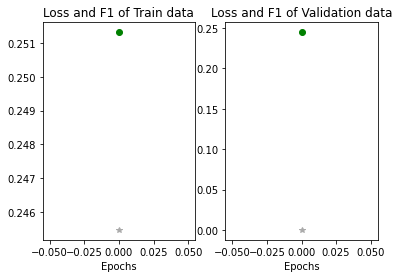

[I 2022-06-08 18:35:36,154] Trial 20 finished with value: 0.0 and parameters: {'learning_rate': 0.0003528995964672154, 'weight_decay': 8.311370533813824e-05, 'per_device_train_batch_size': 63}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 73
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 640
model_name : klue/roberta-base, lr : 5.0903548520565514e-05, weight_decay : 9.041016119060306e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000406433, Avg Loss : 0.0728, f1 score : 0.8737
Epoch 0 Total Mean Loss : 0.0671
Epoch 0 Total Mean f1 : 0.8867
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1452 Valid Acc : 0.7975 Valid f1 : 0.7165
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000279174, Avg Loss : 0.0295, f1 score : 0.9620
Epoch 1 Total Mean Loss : 0.0292
Epoch 1 Total Mean f1 : 0.9625
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1662 Valid Acc : 0.7744 Valid f1 : 0.7472
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000151915, Avg Loss : 0.0173, f1 score : 0.9787
Epoch 2 Total Mean Loss : 0.0177
Epoch 2 Total Mean f1 : 0.9778
*****Epoch 2 Train 

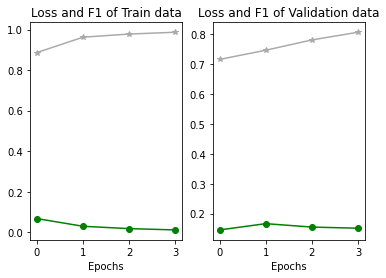

[I 2022-06-08 18:42:32,995] Trial 21 finished with value: 0.807443499617599 and parameters: {'learning_rate': 5.0903548520565514e-05, 'weight_decay': 9.041016119060306e-05, 'per_device_train_batch_size': 73}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 73
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 640
model_name : klue/roberta-base, lr : 6.344732233950684e-05, weight_decay : 0.0002950064884685298, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000506587, Avg Loss : 0.0660, f1 score : 0.9111
Epoch 0 Total Mean Loss : 0.0612
Epoch 0 Total Mean f1 : 0.9169
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1998 Valid Acc : 0.7616 Valid f1 : 0.7761
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000347969, Avg Loss : 0.0283, f1 score : 0.9641
Epoch 1 Total Mean Loss : 0.0280
Epoch 1 Total Mean f1 : 0.9641
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1190 Valid Acc : 0.8480 Valid f1 : 0.8251
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:1_loss:0.1190_f1:0.8251.ckpt
*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000189351, Avg Loss : 0.0

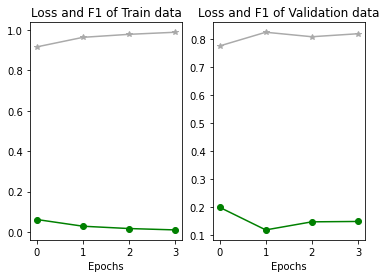

[I 2022-06-08 18:49:35,861] Trial 22 finished with value: 0.8250963188590674 and parameters: {'learning_rate': 6.344732233950684e-05, 'weight_decay': 0.0002950064884685298, 'per_device_train_batch_size': 73}. Best is trial 13 with value: 0.8345308559036908.



------------------------------------------


batch_size : 45
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1040
model_name : klue/roberta-base, lr : 7.632181892333855e-05, weight_decay : 0.000319471637185035, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000668550, Avg Loss : 0.0880, f1 score : 0.8805
Epoch: 0, Step : 256, LR : 0.0000574615, Avg Loss : 0.0531, f1 score : 0.9303
Epoch 0 Total Mean Loss : 0.0703
Epoch 0 Total Mean f1 : 0.9057
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1665 Valid Acc : 0.8141 Valid f1 : 0.8111
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000477745, Avg Loss : 0.0369, f1 score : 0.9522
Epoch: 1, Step : 256, LR : 0.0000383811, Avg Loss : 0.0335, f1 score : 0.9557
Epoch 1 Total Mean Loss : 0.0350
Epoch 1 Total Mean f1 : 0.9542
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1265 Valid Acc : 0.8251 Valid f1 : 0.8035
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch:

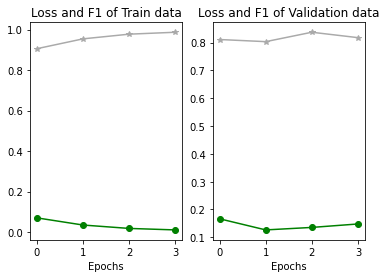

[I 2022-06-08 18:56:51,789] Trial 23 finished with value: 0.8373039614965615 and parameters: {'learning_rate': 7.632181892333855e-05, 'weight_decay': 0.000319471637185035, 'per_device_train_batch_size': 45}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 45
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1040
model_name : klue/roberta-base, lr : 0.00016736388371861482, weight_decay : 0.0017961547803924181, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001466043, Avg Loss : 0.1427, f1 score : 0.7972
Epoch: 0, Step : 256, LR : 0.0001260057, Avg Loss : 0.1113, f1 score : 0.8586
Epoch 0 Total Mean Loss : 0.1268
Epoch 0 Total Mean f1 : 0.8281
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2404 Valid Acc : 0.6696 Valid f1 : 0.7011
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001047634, Avg Loss : 0.1137, f1 score : 0.8597
Epoch: 1, Step : 256, LR : 0.0000841647, Avg Loss : 0.0961, f1 score : 0.8864
Epoch 1 Total Mean Loss : 0.1045
Epoch 1 Total Mean f1 : 0.8735
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.2322 Valid Acc : 0.7172 Valid f1 : 0.7248
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoc

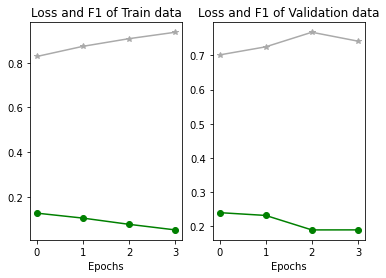

[I 2022-06-08 19:04:02,280] Trial 24 finished with value: 0.7673694163274486 and parameters: {'learning_rate': 0.00016736388371861482, 'weight_decay': 0.0017961547803924181, 'per_device_train_batch_size': 45}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 37
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1264
model_name : klue/roberta-base, lr : 8.893919749970807e-05, weight_decay : 0.005289395501302799, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000798623, Avg Loss : 0.0917, f1 score : 0.8687
Epoch: 0, Step : 256, LR : 0.0000708558, Avg Loss : 0.0615, f1 score : 0.9219
Epoch 0 Total Mean Loss : 0.0723
Epoch 0 Total Mean f1 : 0.9029
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1531 Valid Acc : 0.7881 Valid f1 : 0.7918
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000576275, Avg Loss : 0.0374, f1 score : 0.9503
Epoch: 1, Step : 256, LR : 0.0000486210, Avg Loss : 0.0364, f1 score : 0.9551
Epoch 1 Total Mean Loss : 0.0355
Epoch 1 Total Mean f1 : 0.9548
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1741 Valid Acc : 0.7983 Valid f1 : 0.8014
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch:

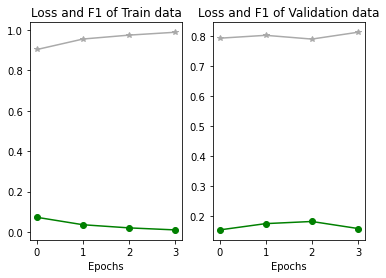

[I 2022-06-08 19:11:20,344] Trial 25 finished with value: 0.8116522960521871 and parameters: {'learning_rate': 8.893919749970807e-05, 'weight_decay': 0.005289395501302799, 'per_device_train_batch_size': 37}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 47
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 996
model_name : klue/roberta-base, lr : 0.0005543986525735047, weight_decay : 0.0006751826865502066, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0004825940, Avg Loss : 0.2515, f1 score : 0.0838
Epoch 0 Total Mean Loss : 0.2505
Epoch 0 Total Mean f1 : 0.0434
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2475 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 43.671849727630615초
green is loss, gray is f1


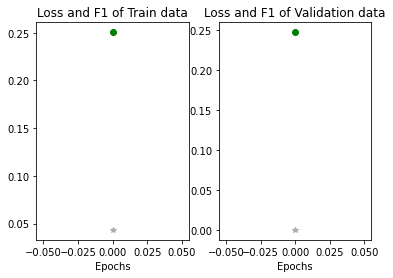

[I 2022-06-08 19:13:18,431] Trial 26 finished with value: 0.0 and parameters: {'learning_rate': 0.0005543986525735047, 'weight_decay': 0.0006751826865502066, 'per_device_train_batch_size': 47}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 25
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1868
model_name : klue/roberta-base, lr : 8.211729770923923e-05, weight_decay : 0.009501890779124802, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000764465, Avg Loss : 0.0991, f1 score : 0.8285
Epoch: 0, Step : 256, LR : 0.0000708196, Avg Loss : 0.0650, f1 score : 0.9224
Epoch: 0, Step : 384, LR : 0.0000651927, Avg Loss : 0.0607, f1 score : 0.9290
Epoch 0 Total Mean Loss : 0.0761
Epoch 0 Total Mean f1 : 0.8944
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1810 Valid Acc : 0.7818 Valid f1 : 0.6830
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000559171, Avg Loss : 0.0489, f1 score : 0.9321
Epoch: 1, Step : 256, LR : 0.0000502903, Avg Loss : 0.0476, f1 score : 0.9414
Epoch: 1, Step : 384, LR : 0.0000446634, Avg Loss : 0.0455, f1 score : 0.9458
Epoch 1 Total Mean Loss : 0.0459
Epoch 1 Total Mean f1 : 0.9418
*****Epoch 1 Train Finish*****

*****Ep

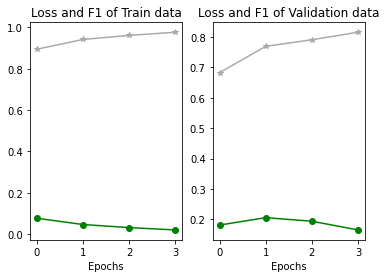

[I 2022-06-08 19:20:36,260] Trial 27 finished with value: 0.8159039541265318 and parameters: {'learning_rate': 8.211729770923923e-05, 'weight_decay': 0.009501890779124802, 'per_device_train_batch_size': 25}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 41
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 1140
model_name : klue/roberta-base, lr : 0.0002274416763977539, weight_decay : 0.0002780540324376309, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002017049, Avg Loss : 0.2528, f1 score : 0.3166
Epoch: 0, Step : 256, LR : 0.0001761675, Avg Loss : 0.2505, f1 score : 0.1821
Epoch 0 Total Mean Loss : 0.2515
Epoch 0 Total Mean f1 : 0.2416
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2472 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 44.20213174819946초
green is loss, gray is f1


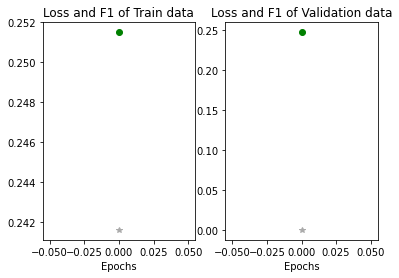

[I 2022-06-08 19:22:34,888] Trial 28 finished with value: 0.0 and parameters: {'learning_rate': 0.0002274416763977539, 'weight_decay': 0.0002780540324376309, 'per_device_train_batch_size': 41}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 51
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 916
model_name : klue/roberta-base, lr : 0.000125325617701243, weight_decay : 0.00066887058711862, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001076760, Avg Loss : 0.0948, f1 score : 0.8619
Epoch 0 Total Mean Loss : 0.0804
Epoch 0 Total Mean f1 : 0.8878
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1701 Valid Acc : 0.7697 Valid f1 : 0.7272
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000763446, Avg Loss : 0.0479, f1 score : 0.9365
Epoch 1 Total Mean Loss : 0.0477
Epoch 1 Total Mean f1 : 0.9393
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1419 Valid Acc : 0.8065 Valid f1 : 0.7842
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000450132, Avg Loss : 0.0291, f1 score : 0.9594
Epoch 2 Total Mean Loss : 0.0275
Epoch 2 Total Mean f1 : 0.9622
*****Epoch 2 Train Fini

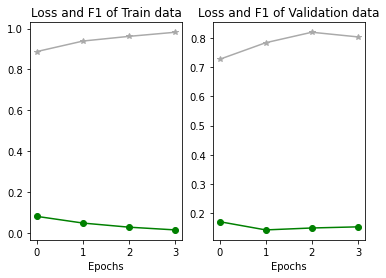

[I 2022-06-08 19:29:41,013] Trial 29 finished with value: 0.8200858815565482 and parameters: {'learning_rate': 0.000125325617701243, 'weight_decay': 0.00066887058711862, 'per_device_train_batch_size': 51}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 60
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 780
model_name : klue/roberta-base, lr : 0.0005539612807009426, weight_decay : 0.0044074872346177175, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0004623446, Avg Loss : 0.2530, f1 score : 0.1225
Epoch 0 Total Mean Loss : 0.2518
Epoch 0 Total Mean f1 : 0.0811
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2470 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 42.69281268119812초
green is loss, gray is f1


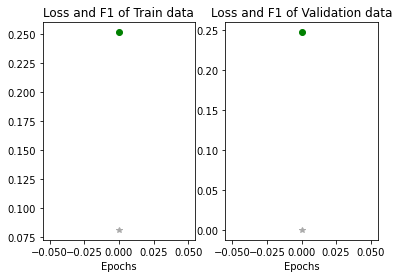

[I 2022-06-08 19:31:38,167] Trial 30 finished with value: 0.0 and parameters: {'learning_rate': 0.0005539612807009426, 'weight_decay': 0.0044074872346177175, 'per_device_train_batch_size': 60}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 82
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 572
model_name : klue/roberta-base, lr : 7.351955303424214e-05, weight_decay : 0.0003697851564032416, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000569391, Avg Loss : 0.0765, f1 score : 0.8902
Epoch 0 Total Mean Loss : 0.0728
Epoch 0 Total Mean f1 : 0.8958
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1205 Valid Acc : 0.8435 Valid f1 : 0.8241
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000385592, Avg Loss : 0.0283, f1 score : 0.9625
Epoch 1 Total Mean Loss : 0.0285
Epoch 1 Total Mean f1 : 0.9623
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1702 Valid Acc : 0.7983 Valid f1 : 0.8021
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000201793, Avg Loss : 0.0167, f1 score : 0.9793
Epoch 2 Total Mean Loss : 0.0170
Epoch 2 Total Mean f1 : 0.9791
*****Epoch 2 Train F

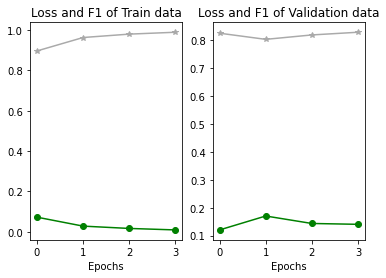

[I 2022-06-08 19:38:36,071] Trial 31 finished with value: 0.8275416963595144 and parameters: {'learning_rate': 7.351955303424214e-05, 'weight_decay': 0.0003697851564032416, 'per_device_train_batch_size': 82}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 82
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 572
model_name : klue/roberta-base, lr : 7.18024269533738e-05, weight_decay : 0.0004618994107645463, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000556092, Avg Loss : 0.0650, f1 score : 0.9021
Epoch 0 Total Mean Loss : 0.0628
Epoch 0 Total Mean f1 : 0.9062
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1591 Valid Acc : 0.7873 Valid f1 : 0.7921
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000376586, Avg Loss : 0.0297, f1 score : 0.9605
Epoch 1 Total Mean Loss : 0.0300
Epoch 1 Total Mean f1 : 0.9602
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1379 Valid Acc : 0.8314 Valid f1 : 0.8272
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000197080, Avg Loss : 0.0151, f1 score : 0.9815
Epoch 2 Total Mean Loss : 0.0155
Epoch 2 Total Mean f1 : 0.9812
*****Epoch 2 Train Fi

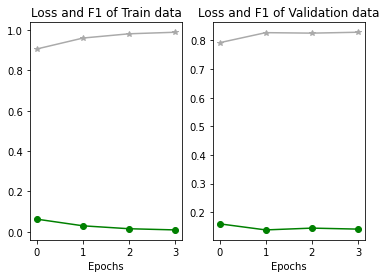

[I 2022-06-08 19:45:32,602] Trial 32 finished with value: 0.8286582940676306 and parameters: {'learning_rate': 7.18024269533738e-05, 'weight_decay': 0.0004618994107645463, 'per_device_train_batch_size': 82}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 83
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 564
model_name : klue/roberta-base, lr : 0.00013544743534145618, weight_decay : 0.0004220921683148312, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001044674, Avg Loss : 0.2511, f1 score : 0.1310
Epoch 0 Total Mean Loss : 0.2509
Epoch 0 Total Mean f1 : 0.1198
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2473 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 40.5898962020874초
green is loss, gray is f1


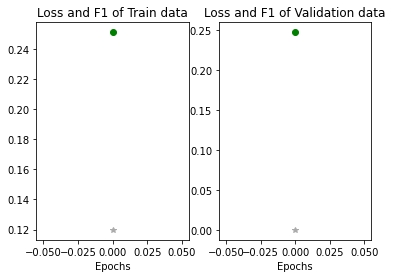

[I 2022-06-08 19:47:27,587] Trial 33 finished with value: 0.0 and parameters: {'learning_rate': 0.00013544743534145618, 'weight_decay': 0.0004220921683148312, 'per_device_train_batch_size': 83}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 79
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 592
model_name : klue/roberta-base, lr : 6.843634700237655e-05, weight_decay : 0.000197467151098045, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000535237, Avg Loss : 0.0708, f1 score : 0.8940
Epoch 0 Total Mean Loss : 0.0671
Epoch 0 Total Mean f1 : 0.9002
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1383 Valid Acc : 0.8120 Valid f1 : 0.7989
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000364146, Avg Loss : 0.0315, f1 score : 0.9590
Epoch 1 Total Mean Loss : 0.0308
Epoch 1 Total Mean f1 : 0.9601
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1227 Valid Acc : 0.8380 Valid f1 : 0.8075
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000193055, Avg Loss : 0.0171, f1 score : 0.9787
Epoch 2 Total Mean Loss : 0.0167
Epoch 2 Total Mean f1 : 0.9795
*****Epoch 2 Train Fi

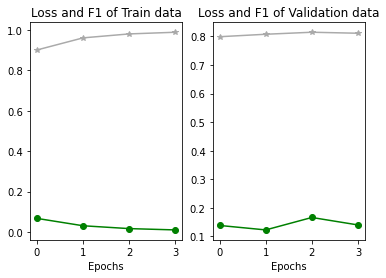

[I 2022-06-08 19:54:24,487] Trial 34 finished with value: 0.8145497538678943 and parameters: {'learning_rate': 6.843634700237655e-05, 'weight_decay': 0.000197467151098045, 'per_device_train_batch_size': 79}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 87
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 540
model_name : klue/roberta-base, lr : 0.00015541631317394909, weight_decay : 6.0112139884435e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001182891, Avg Loss : 0.1124, f1 score : 0.8361
Epoch 0 Total Mean Loss : 0.1101
Epoch 0 Total Mean f1 : 0.8399
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2153 Valid Acc : 0.7285 Valid f1 : 0.7451
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000794350, Avg Loss : 0.0618, f1 score : 0.9222
Epoch 1 Total Mean Loss : 0.0608
Epoch 1 Total Mean f1 : 0.9230
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1764 Valid Acc : 0.7671 Valid f1 : 0.7764
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000405809, Avg Loss : 0.0395, f1 score : 0.9506
Epoch 2 Total Mean Loss : 0.0392
Epoch 2 Total Mean f1 : 0.9509
*****Epoch 2 Train Fi

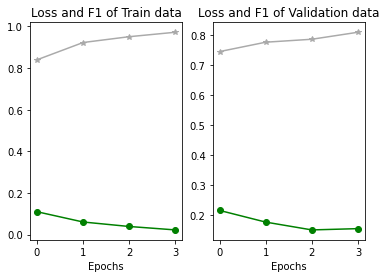

[I 2022-06-08 20:01:21,215] Trial 35 finished with value: 0.8095983892325136 and parameters: {'learning_rate': 0.00015541631317394909, 'weight_decay': 6.0112139884435e-05, 'per_device_train_batch_size': 87}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 82
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 572
model_name : klue/roberta-base, lr : 0.0001100022678249792, weight_decay : 0.0009020230471502597, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000851941, Avg Loss : 0.0848, f1 score : 0.8767
Epoch 0 Total Mean Loss : 0.0811
Epoch 0 Total Mean f1 : 0.8824
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1987 Valid Acc : 0.7623 Valid f1 : 0.7749
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000576935, Avg Loss : 0.0371, f1 score : 0.9533
Epoch 1 Total Mean Loss : 0.0373
Epoch 1 Total Mean f1 : 0.9528
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1701 Valid Acc : 0.7910 Valid f1 : 0.7876
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000301929, Avg Loss : 0.0245, f1 score : 0.9695
Epoch 2 Total Mean Loss : 0.0239
Epoch 2 Total Mean f1 : 0.9703
*****Epoch 2 Train F

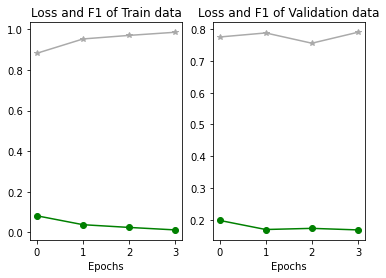

[I 2022-06-08 20:08:18,805] Trial 36 finished with value: 0.789806916396809 and parameters: {'learning_rate': 0.0001100022678249792, 'weight_decay': 0.0009020230471502597, 'per_device_train_batch_size': 82}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 77
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 608
model_name : klue/roberta-base, lr : 0.0029720618508421717, weight_decay : 0.0015745436871768513, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0023414764, Avg Loss : 0.2537, f1 score : 0.2816
Epoch 0 Total Mean Loss : 0.2532
Epoch 0 Total Mean f1 : 0.2390
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.2481 Valid Acc : 0.5825 Valid f1 : 0.0000
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 40.00025510787964초
green is loss, gray is f1


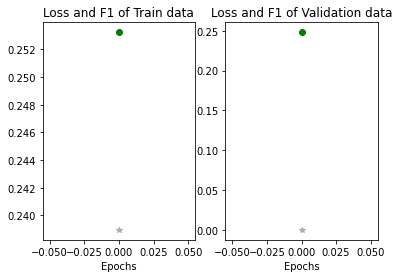

[I 2022-06-08 20:10:13,636] Trial 37 finished with value: 0.0 and parameters: {'learning_rate': 0.0029720618508421717, 'weight_decay': 0.0015745436871768513, 'per_device_train_batch_size': 77}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 84
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 556
model_name : klue/roberta-base, lr : 7.303728559792305e-05, weight_decay : 0.0001322508857835097, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000560916, Avg Loss : 0.0704, f1 score : 0.8845
Epoch 0 Total Mean Loss : 0.0684
Epoch 0 Total Mean f1 : 0.8891
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1661 Valid Acc : 0.7826 Valid f1 : 0.7818
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000378323, Avg Loss : 0.0298, f1 score : 0.9619
Epoch 1 Total Mean Loss : 0.0296
Epoch 1 Total Mean f1 : 0.9622
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1898 Valid Acc : 0.7634 Valid f1 : 0.7766
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000195729, Avg Loss : 0.0179, f1 score : 0.9773
Epoch 2 Total Mean Loss : 0.0173
Epoch 2 Total Mean f1 : 0.9782
*****Epoch 2 Train F

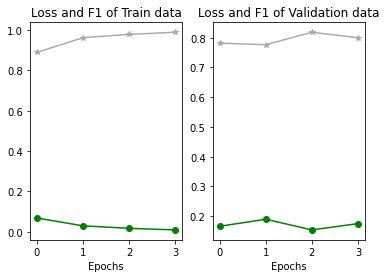

[I 2022-06-08 20:17:09,535] Trial 38 finished with value: 0.8184930449228384 and parameters: {'learning_rate': 7.303728559792305e-05, 'weight_decay': 0.0001322508857835097, 'per_device_train_batch_size': 84}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------


batch_size : 69
batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Total train steps with 4 epochs: 680
model_name : klue/roberta-base, lr : 5.2635585672403106e-05, weight_decay : 0.0003762889687857567, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000426503, Avg Loss : 0.0812, f1 score : 0.8640
Epoch 0 Total Mean Loss : 0.0736
Epoch 0 Total Mean f1 : 0.8791
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.1150 Valid Acc : 0.8461 Valid f1 : 0.8227
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.1150_f1:0.8227.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000294914, Avg Loss : 0.0285, f1 score : 0.9628
Epoch 1 Total Mean Loss : 0.0288
Epoch 1 Total Mean f1 : 0.9628
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.1331 Valid Acc : 0.8178 Valid f1 : 0.8067
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000163325, Avg Loss : 0.

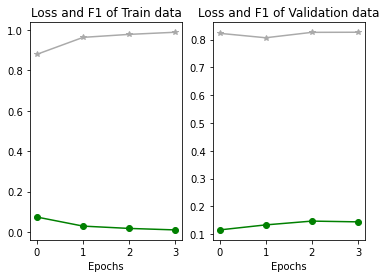

[I 2022-06-08 20:24:13,672] Trial 39 finished with value: 0.8265908777471256 and parameters: {'learning_rate': 5.2635585672403106e-05, 'weight_decay': 0.0003762889687857567, 'per_device_train_batch_size': 69}. Best is trial 23 with value: 0.8373039614965615.



------------------------------------------




<Figure size 432x288 with 0 Axes>

In [26]:
print('klue/roberta-base\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search', direction='maximize') 
# Optimize the objective using 5 different trials 
study.optimize(objective, n_trials=40)

In [ ]:
# print(f'study.best_trial.value : {study.best_trial.value}') 
# print(f'study.best_params : {study.best_params}') 
# print(f'study.trials : {study.trials}')
# optuna.visualization.plot_edf(study)

# 추가학습


In [ ]:
train_batch_size = 32
model_name = 'klue/roberta-base'

train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')
learning_rate = 2e-05
weight_decay = 0.01

model, optimizer, scheduler = initializer(train_dataloader, 20, model_name, learning_rate, weight_decay)

start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 20, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

draw_plot(train_dict, valid_dict, 0)

# Test : 최적화된 모델로 KLUE-sts Validation 문장 test

csv파일로 score과 두 문장 저장

In [18]:
model_name = 'epoch:0_loss:0.1288_f1:0.8392.ckpt'
checkpoint = torch.load(f'/content/drive/MyDrive/Colab Notebooks/nlp/{model_name}')
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss', 'f1'])

In [25]:
def test(model, test_dataloader):
    loss_fct = nn.MSELoss()
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc, total_f1, total_pearson= 0,0, 0, 0
    prediction = {'probs' : [], 'batch_input_ids' : []}   # batch_input_ids는 문장 확인을 위해 넣어둠.

    for step, batch in enumerate(test_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
        labels = torch.tensor([[1, 0] if label == 1 else [0, 1] for label in batch_label]).to(device)

        prediction['batch_input_ids'].extend(batch_input['input_ids'])
        
        # gradient 계산하지 않음
        with torch.no_grad():
            probs = model(**batch_input)
        pred = torch.argmin(probs, dim=1).cpu()
        
        prediction['probs'].extend(probs)

        # loss
        loss = loss_fct(probs.to(torch.float32), labels.to(torch.float32))
        total_loss += loss.item()
        
        # accuracy
        acc = 0
        for p, b in zip(pred, batch_label) :
          if p == b :
            acc += 1
        
        acc = acc / len(probs)
        total_acc+=acc
        

        # f1-score
        f1 = f1_score(pred, [b.cpu() for b in batch_label])
        total_f1 += f1

    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)
    total_f1 = total_f1/(step+1)
    return prediction, total_loss, total_acc, total_f1

In [26]:
valid_dataset = CustomDataset(dataset['validation'])
validation_loader = make_dataloader(valid_dataset, 'klue/roberta-base', 32, 'valid')

model = CustomSTS(model_name='klue/roberta-base')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
prediction, total_loss, total_acc, total_f1 = test(model, validation_loader)

batch_size : 32


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [50]:
import pandas as pd
df = pd.DataFrame({'sentence1' : [data['sentence1'] for data in dataset['validation']],
                   'sentence2' : [data['sentence2'] for data in dataset['validation']],
                   'binary_label' : [data['labels']['binary-label'] for data in dataset['validation']]
                   })
df.head()

,sentence1,sentence2,binary_label
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",1
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,0
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,0
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",1
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,0


In [51]:
# prediction['probs'] = [p.item() for p in prediction['probs']]
df['pred'] = [torch.argmin(p).item() for p in prediction['probs']]
df['prob'] = [p.cpu().numpy() for p in prediction['probs']]
df.head()

,sentence1,sentence2,binary_label,pred,prob
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",1,1,"[0.9838352, 0.016164767]"
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,0,0,"[0.025290715, 0.9747093]"
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,0,0,"[0.022371277, 0.97762877]"
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",1,1,"[0.98333204, 0.016667979]"
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,0,0,"[0.035525218, 0.96447474]"


In [54]:
df[df['pred'] != df['binary_label']]

,sentence1,sentence2,binary_label,pred,prob
10,라디오 듣는 건 금지되어있어,라디오 듣는건 삼가주세요,0,1,"[0.98154056, 0.018459415]"
21,와이키키 중심지로 이동이 편리한 위치에 있습니다.,와이키키 센터에 편리하게 위치해 있습니다.,0,1,"[0.97817594, 0.021824026]"
25,집안에서 효율적으로 환기하고 싶을 때 뭐가 필요해?,발코니말고 집안에서 효율적으로 환기할 때 필요한 것은?,0,1,"[0.6507532, 0.3492468]"
26,기본적인 어매니티 외에 커피머신 제빙기 토스터와 전자레인지등은 2층 로비 플로어...,커피머신용 토스터와 전자레인지도 2층 로비 층에서 무료로 이용하실 수 있습니다.,0,1,"[0.90808976, 0.09191025]"
27,신발 신고다니는 숙소라 불편하신 분들은 슬리퍼챙겨오시는게 좋을듯여,슬리퍼 등 실내화를 챙기시는게 좋을 것 같아요.,1,0,"[0.041293427, 0.9587066]"
...,...,...,...,...,...
494,들어올때 말고 나갈때 방범모드 확인하는 건 어때?,외출 시 방범 모드는 어떻게 바꿔?,0,1,"[0.964011, 0.03598903]"
505,한메일 계정을 더 만드는건 유료니 그만 만들어,한메일 계정은 그만 만들고 네이버 계정으로 만들어,0,1,"[0.6371587, 0.3628413]"
507,특히 직불금 도입 과정에서 중소규모 농가를 더 배려했습니다.,"특히, 중소 농부들은 직불금을 도입하는 과정에서 더 많은 배려를 했습니다.",0,1,"[0.98425484, 0.015745124]"
514,"문체부는 이를 연차적으로 확대, 시행해 학교운동부와 스포츠클럽 간의 연계를 강화한다.",문화체육관광부는 학교스포츠학과와 스포츠클럽의 연계성을 강화하기 위해 매년 이 프로그...,0,1,"[0.98391736, 0.01608258]"


In [55]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from scipy.stats import pearsonr
print(f'정확도 : {accuracy_score(df.binary_label, df.pred):.4f}')
print(f'recall : {recall_score(df.binary_label, df.pred):.4f}')
print(f'precision : {precision_score(df.binary_label, df.pred):.4f}')
print(f'f1_score : {f1_score(df.binary_label, df.pred):.4f}')

정확도 : 0.8516
recall : 0.9636
precision : 0.7544
f1_score : 0.8463


In [56]:
df.to_csv('klue-dataset-validation-prediction_roberta.csv')